# Data and module import

In [1]:
import pandas as pd; import numpy as np; import pymc as pm; from scipy import stats; import arviz as az

In [2]:
#Accidents after June 2008
data = pd.read_csv("https://raw.githubusercontent.com/javmencia/STA303/main/cyclingData.csv")

## Data cleaning

In [3]:
def TimeGetter(time):
    ftr = [3600,60,1]
    t = sum([a*b for a,b in zip(ftr, map(int,time.split(':')))])
    if t<6*3600 or t>22*3600:
        return "Night"
    elif t<9*3600:
        return "Morning"
    elif t<14*3600:
        return "Midday"
    elif t<18*3600:
        return "Afternoon"
    else:
        return "Evening"

In [4]:
# Missing data
# Substitute missing data with NA
data = data.replace({'Missing Data': np.NAN, 'Other': np.NAN, 'Unknown': np.NAN, 'Missing data': np.NAN})
# Assume data is missing completely at random and remove
data = data.dropna()
#data["Road_conditions"].unique()

# Data wrangling
# Day to weekday(1) and weekend(0)
data = data.replace({'Monday':1, 'Tuesday':1, 'Wednesday':1, 'Thursday':1, 'Friday': 1, 'Saturday':0, 'Sunday': 0})
# TimeDay variable, categorical

data["TimeDay"] = [TimeGetter(i) for i in data["Time"]]
# Road conditions: Dry or not
data["DryRoad"] = [1 if i=="Dry" else 0 for i in data["Road_conditions"]]

# Weather: Clear or not
data["Clear"] = [1 if i=="Clear" else 0 for i in data["Weather_conditions"]]

# Light conditions: Dark or not
data["Dark"] = [1 if i=="Darkness no lights" else 0 for i in data["Light_conditions"]]
print(data['Light_conditions'].unique())
# Road type: Binary whether it is Dual carriageway, use EDA to justify
data["DualCarriageway"] = [1 if i=="Dual carriageway" else 0 for i in data["Road_type"]]
# Age: over 55
data["over55"] = [1 if i in ["56 to 65", "66 to 75"] else 0 for i in data["Age_Grp"]]

# Severity_binary: Severe or not
data["Severity_binary"] = [0 if i=="Slight" else 1 for i in data["Severity"]]

# Night binary
data["Night"] = [1 if i=="Night" else 0 for i in data["TimeDay"]]
# Morning binary
data["Morning"] = [1 if i=="Morning" else 0 for i in data["TimeDay"]]
# Midday binary
data["Midday"] = [1 if i=="Midday" else 0 for i in data["TimeDay"]]
# Afternoon binary
data["Afternoon"] = [1 if i=="Afternoon" else 0 for i in data["TimeDay"]]
# Evening binary
data["Evening"] = [1 if i=="Evening" else 0 for i in data["TimeDay"]]
data['Gender']= [1 if i=="Male" else 0 for i in data["Gender"]]

cleandata = data[["Severity_binary", "Day", "Speed_limit", "DryRoad", "Clear", "Gender", "over55", "DualCarriageway", "TimeDay", "Night", "Morning", "Midday", "Afternoon", "Evening", "Dark"]]


['Darkness lights lit' 'Daylight' 'Darkness no lights']


In [5]:
subset = cleandata[-100:]

x1 = subset['DryRoad']
x1 = pd.Series(x1).array

x2 = subset['Clear']
x2 = pd.Series(x2).array

x3 = subset['DualCarriageway']
x3 = pd.Series(x3).array

x4 = subset['Dark']
x4 = pd.Series(x4).array

x5 = subset['Speed_limit']
x5 = pd.Series(x5).array

x6 = subset["Night"]
x6 = pd.Series(x6).array

x7 = subset["Morning"]
x7 = pd.Series(x7).array

x8 = subset["Midday"]
x8 = pd.Series(x8).array

x9 = subset["Afternoon"]
x9 = pd.Series(x9).array

x10 = subset["Evening"]
x10 = pd.Series(x10).array

y = subset['Severity_binary']
y = pd.Series(y).array

num_obs = len(y)

# We want model with three predictors: When, What, Who

# Hierarchical structure on Time/Day betas

In [ ]:
with pm.Model() as timeday_model:
    # pWeekdayday Probability of being a weekday
    pWeekday = pm.Beta('pWeekday', alpha=1, beta=1)

    # Time weekday probabilities
    pNight = pm.Beta('pNight', alpha=1, beta=1)
    pMorningBase = pm.Beta('pMorningBase', alpha=1, beta=1)
    pMiddayBase = pm.Beta('pMiddayBase', alpha=1, beta=1)
    pAfternoonBase = pm.Beta('pAfternoonBase', alpha=1, beta=1)
    pEvening = pm.Beta('pEvening', alpha=1, beta=1)

    # Time weekend probabilities
    pMorChange = pm.Beta('pMorChange', alpha=1, beta=1)
    pMidChange = pm.Beta('pMidChange', alpha=1, beta=1)
    pAftChange = pm.Beta('pAftChange', alpha=1, beta=1)


    # pMorningBase + pWeekday*(1-pMorningBase)*pMorChange
    no_negatives_2 = pm.math.switch(pm.math.lt(pMorningBase + pWeekday * (1 - pMorningBase) * pMorChange, 0), 0,
                                     pMorningBase + pWeekday * (1 - pMorningBase) * pMorChange)
    in_unit_interval_2 = pm.math.switch(pm.math.gt(no_negatives_2, 1), 1,
                                        pMorningBase + pWeekday * (1 - pMorningBase) * pMorChange)
    pMorning = pm.Deterministic('pMorning', in_unit_interval_2)

    # pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange
    no_negatives_3 = pm.math.switch(pm.math.lt(pMiddayBase - pWeekday * (1 - pMiddayBase) * pMidChange, 0), 0,
                                     pMiddayBase - pWeekday * (1 - pMiddayBase) * pMidChange)
    in_unit_interval_3 = pm.math.switch(pm.math.gt(no_negatives_3, 1), 1,
                                        pMiddayBase - pWeekday * (1 - pMiddayBase) * pMidChange)
    pMidday = pm.Deterministic('pMidday', in_unit_interval_3)

    # pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange
    no_negatives_4 = pm.math.switch(pm.math.lt(pAfternoonBase + pWeekday * (1 - pAfternoonBase) * pAftChange, 0), 0,
                                     pAfternoonBase + pWeekday * (1 - pAfternoonBase) * pAftChange)
    in_unit_interval_4 = pm.math.switch(pm.math.gt(no_negatives_4, 1), 1,
                                        pAfternoonBase + pWeekday * (1 - pAfternoonBase) * pAftChange)
    pAfternoon = pm.Deterministic('pAfternoon', in_unit_interval_4)

    # Linear combination of predictors
    logit_p = pNight * x6 + pMorning * x7 + pMidday * x8 + pAfternoon * x9 + pEvening * x10
    logit_p = pm.Deterministic('logit_p', logit_p)

    y = pm.Bernoulli('y', logit_p=logit_p, observed=y)
    timedaydata = pm.sample()

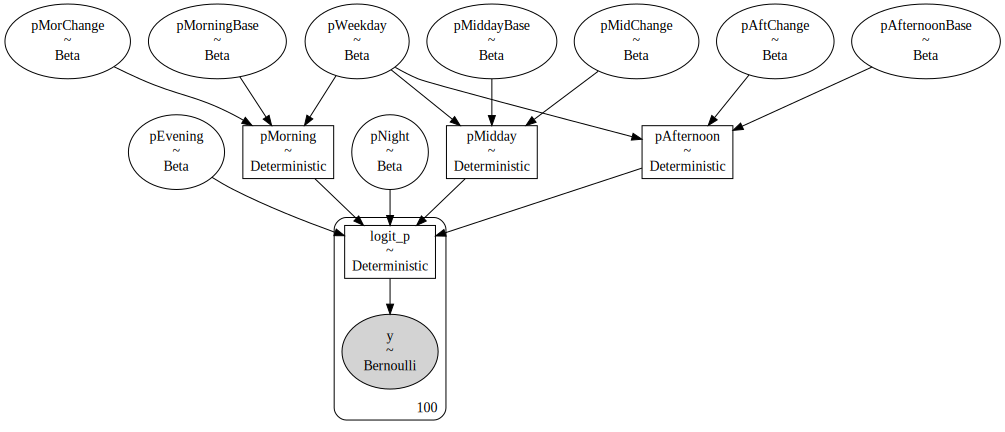

In [ ]:
pm.model_to_graphviz(timeday_model)

# Posterior inference Part 1

In [ ]:
print("number of MCMC samples:", timedaydata.posterior['pWeekday'].values.flatten().shape[-1])
az.summary(timedaydata, round_to=2)

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pWeekday,0.32,0.26,0.00,0.83,0.01,0.00,2052.73,1440.39,1.00
pNight,0.45,0.28,0.00,0.90,0.01,0.00,2222.93,1273.33,1.00
pMorningBase,0.17,0.15,0.00,0.45,0.00,0.00,2359.13,1302.42,1.00
pMiddayBase,0.21,0.17,0.00,0.52,0.00,0.00,2781.50,1107.63,1.01
pAfternoonBase,0.16,0.14,0.00,0.42,0.00,0.00,2008.20,1123.06,1.00
...,...,...,...,...,...,...,...,...,...
logit_p[95],0.24,0.16,0.01,0.53,0.00,0.00,2711.07,1332.81,1.00
logit_p[96],0.25,0.17,0.01,0.56,0.00,0.00,2223.62,1576.65,1.00
logit_p[97],0.05,0.26,-0.47,0.54,0.01,0.01,2479.00,1217.93,1.00
logit_p[98],0.26,0.21,0.00,0.65,0.00,0.00,2883.38,1265.38,1.00


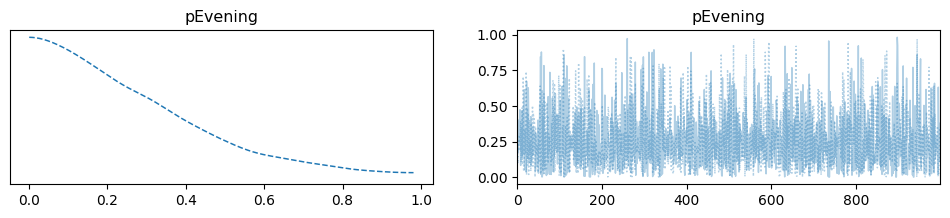

In [ ]:
az.plot_trace(timedaydata, combined = True,var_names ='pEvening' );

Variable selection for the conditions factors using Spike and Slab

In [ ]:
predictors = ['DryRoad', 'Dark', 'DualCarriageway', 'Clear','Speed_limit']

# Get predictors and target variable as numpy arrays
X = cleandata[predictors].values[-100:]
y = cleandata['Severity_binary'].values[-100:]

# Number of predictors
n_predictors = X.shape[1]

# Define Bayesian binary regression model with spike-and-slab priors for variable selection
with pm.Model() as model:
    # Coefficients for predictors
    slab = pm.Normal('slab', mu=0, sigma=1, shape=n_predictors)

    # Indicator variables for spike-and-slab
    spike = pm.Bernoulli('spike', p=0.5, shape=n_predictors)

    # Create deterministic variable for selected coefficients
    beta = pm.Deterministic('beta', slab * spike)

    # Logistic regression model
    p = pm.math.invlogit(pm.math.dot(X, beta))
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y)
    idata = pm.sample()

    # Sample from the posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=False)

# Extract selected predictors based on posterior samples of gamma
selected_predictors = np.array(predictors)[np.mean(trace['spike'], axis=0) > 0.5]
print("Selected predictors:", selected_predictors)

Selected predictors: ['Dark' 'Clear']


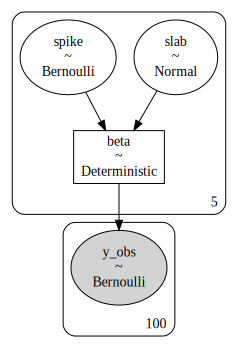

In [ ]:
pm.model_to_graphviz(model)

[Text(1, 0, 'DryRoad'),
 Text(2, 0, 'Dark'),
 Text(3, 0, 'DualCarriageway'),
 Text(4, 0, 'Clear'),
 Text(5, 0, 'Speed_limit')]

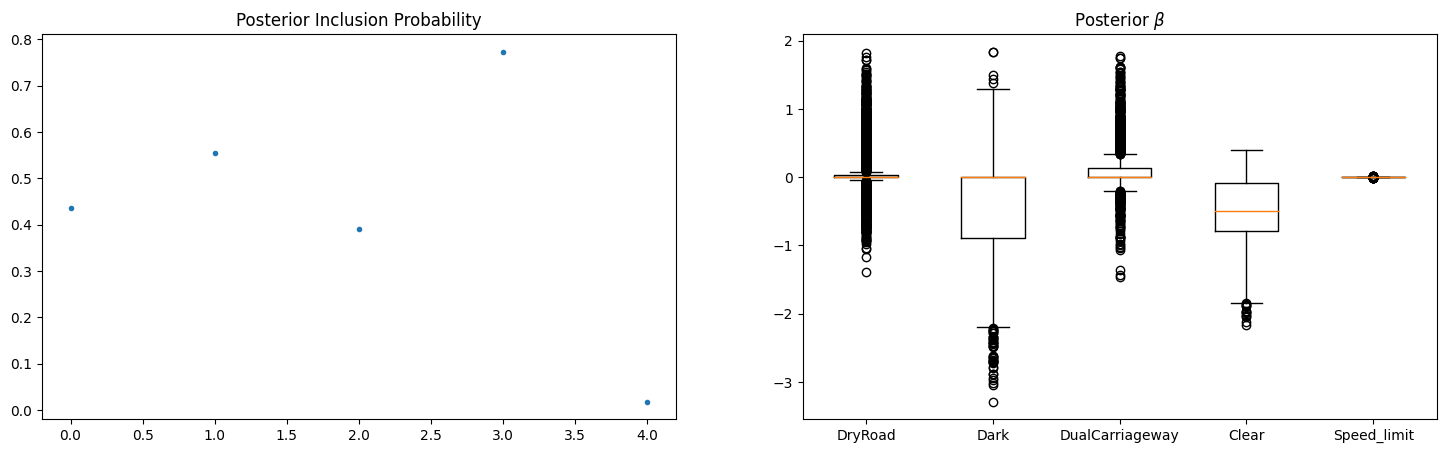

In [ ]:
# Spike and Slab variable selection plots: only the second and the fourth betas have inclusion probability > 0.5
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(18,5));

num_of_beta = 5
ax[0].plot(idata.posterior['spike'].values.reshape((-1,num_of_beta)).mean(axis=0),'.');
ax[0].set_title('Posterior Inclusion Probability');
ax[1].boxplot(idata.posterior['beta'].values.reshape((-1,num_of_beta)));
ax[1].set_title('Posterior $\\beta$');
ax[1].set_xticklabels(['DryRoad', 'Dark', 'DualCarriageway', 'Clear','Speed_limit'])

In the plot above we see that DryRoad and DualCarriageway were both not selected and they were slabbed to zero

# Combine selected predictors with hierarchical model established earlier

In [ ]:
with pm.Model() as complete_model:

    # pWeekday Probablity of being a weekday
    pWeekday = pm.Beta('pWeekday', alpha=1, beta=1)

    # Time weekday probabilities
    pNight= pm.Beta('pNight', alpha=1, beta=1) ## = p1
    pMorningBase= pm.Beta('pMorningBase', alpha=1, beta=1)
    pMiddayBase= pm.Beta('pMiddayBase', alpha=1, beta=1)
    pAfternoonBase= pm.Beta('pAfternoonBase', alpha=1, beta=1)
    pEvening= pm.Beta('pEvening', alpha=1, beta=1) ## = p5
    # Time weekend probabilities
    pMorChange= pm.Beta('pMorChange', alpha=1, beta=1)
    pMidChange= pm.Beta('pMidChange', alpha=1, beta=1)
    pAftChange= pm.Beta('pAftChange', alpha=1, beta=1)

    # pMorningBase + pWeekday*(1-pMorningBase)*pMorChange
    no_negatives_2 = pm.math.switch(pm.math.lt(pMorningBase + pWeekday*(1-pMorningBase)*pMorChange,0), 0, pMorningBase + pWeekday*(1-pMorningBase)*pMorChange)
    in_unit_interval_2 = pm.math.switch(pm.math.gt(no_negatives_2,1), 1, pMorningBase + pWeekday*(1-pMorningBase)*pMorChange)
    pMorning = pm.Deterministic('pMorning', in_unit_interval_2)

    # pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange
    no_negatives_3 = pm.math.switch(pm.math.lt(pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange,0), 0, pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange)
    in_unit_interval_3 = pm.math.switch(pm.math.gt(no_negatives_3,1), 1, pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange)
    pMidday = pm.Deterministic('pMidday', in_unit_interval_3)

    # pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange
    no_negatives_4 = pm.math.switch(pm.math.lt(pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange,0), 0, pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange)
    in_unit_interval_4 = pm.math.switch(pm.math.gt(no_negatives_4,1), 1, pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange)
    pAfternoon = pm.Deterministic('pAfternoon', in_unit_interval_4)

    # Intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Priors of selected condition predictors
    beta_dark = pm.Normal('beta_dark', mu=0, sigma=1)  # Prior for 'Dark'
    beta_clear = pm.Normal('beta_clear', mu=0, sigma=1)  # Prior for 'Clear'

    # Linear combination of predictors
    logit_p = intercept + pNight*x6 +pMorning*x7 +pMidday*x8 +pAfternoon*x9 +pEvening*x10 + beta_clear*x2 + beta_dark*x4
    logit_p = pm.Deterministic('logit_p',logit_p)

    Y = pm.Bernoulli('Y', logit_p = logit_p, observed=y)

    idata_2 = pm.sample()

In [ ]:
print("number of MCMC samples:", idata_2.posterior['pWeekday'].values.flatten().shape[-1])
az.summary(idata_2, round_to=2)

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.75,0.50,-1.67,0.18,0.01,0.01,1763.82,1399.23,1.01
beta_dark,-0.82,0.80,-2.26,0.68,0.02,0.02,2107.61,1337.60,1.00
beta_clear,-0.36,0.50,-1.35,0.57,0.01,0.01,1809.99,1307.68,1.00
pWeekday,0.49,0.29,0.00,0.93,0.01,0.00,1721.50,1247.83,1.01
pNight,0.47,0.28,0.01,0.92,0.01,0.00,2191.06,1154.07,1.00
...,...,...,...,...,...,...,...,...,...
logit_p[95],-0.40,0.25,-0.89,0.03,0.01,0.00,1927.05,1694.15,1.00
logit_p[96],-0.60,0.31,-1.16,0.02,0.01,0.00,2396.73,1727.08,1.00
logit_p[97],-0.68,0.34,-1.33,-0.07,0.01,0.01,2186.97,1791.14,1.00
logit_p[98],-0.61,0.34,-1.24,0.03,0.01,0.01,2163.99,1549.64,1.00


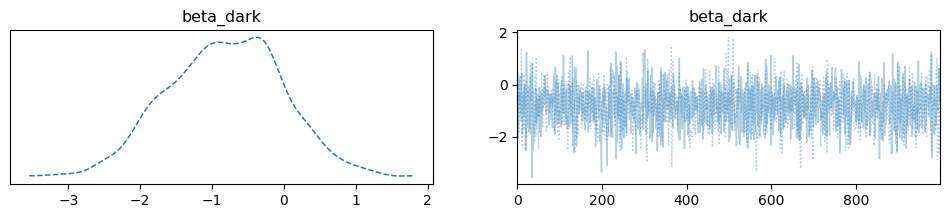

In [ ]:
az.plot_trace(idata_2, combined = True,var_names ='beta_dark' );

# Model diagnostic Part I

In [ ]:
# Baisc regression model for comparison
with pm.Model() as model_basic:
    beta_0 = pm.Normal('beta_0', mu=0, sigma=1)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=1)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=1)
    beta_3 = pm.Normal('beta_3', mu=0, sigma=1)
    beta_4 = pm.Normal('beta_4', mu=0, sigma=1)
    beta_5 = pm.Normal('beta_5', mu=0, sigma=1)
    beta_dark = pm.Normal('beta_dark', mu=0, sigma=1)  # Prior for 'Dark'
    beta_clear = pm.Normal('beta_clear', mu=0, sigma=1)  # Prior for 'Clear'

    # Linear combination of predictors
    logit_p = beta_0 + beta_1*x6 +beta_2*x7 +beta_3*x8 +beta_4*x9 +beta_5*x10 + beta_clear*x2 + beta_dark*x4
    logit_p = pm.Deterministic('logit_p',logit_p)

    Basic_Y = pm.Bernoulli('Basic_Y', logit_p = logit_p, observed=y)

    idata_3 = pm.sample()

In [ ]:
with complete_model:
    trace_complete = pm.sample(2000, tune=1000)
    pm.compute_log_likelihood(trace_complete) # or pass `idata_kwargs={"log_likelihood": True}` to `pm.sample`

with model_basic:
    trace_basic = pm.sample(2000, tune=1000)
    pm.compute_log_likelihood(trace_basic)

In [ ]:
az.waic(trace_complete)

<ipython-input-50-dbc902779305>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.waic(trace_complete)


Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -67.63     2.57
p_waic        2.70        -

In [ ]:
az.waic(trace_basic)

<ipython-input-51-ccd65360a166>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.waic(trace_basic)


Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -68.89     2.90
p_waic        4.44        -

In [ ]:
az.compare({"complete model": trace_complete, "basic model": trace_basic}, ic='waic')

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
complete model,0,-67.629034,2.704320,0.000000,1.0,2.573739,0.000000,False,log
basic model,1,-68.892689,4.444233,1.263655,0.0,2.900816,0.895642,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_waic (log)', ylabel='ranked models'>

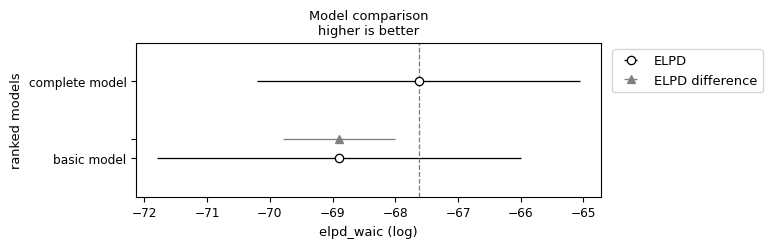

In [ ]:
az.plot_compare(az.compare({ "complete model": trace_complete, "basic model": trace_basic}, ic='waic'), insample_dev=False)

# Mixture model

In [6]:
subset = cleandata[-100:]

x1 = subset['DryRoad']
x1 = pd.Series(x1).array

x2 = subset['Clear']
x2 = pd.Series(x2).array

x3 = subset['DualCarriageway']
x3 = pd.Series(x3).array

x4 = subset['Dark']
x4 = pd.Series(x4).array

x5 = subset['Speed_limit']
x5 = pd.Series(x5).array

x6 = subset["Night"]
x6 = pd.Series(x6).array

x7 = subset["Morning"]
x7 = pd.Series(x7).array

x8 = subset["Midday"]
x8 = pd.Series(x8).array

x9 = subset["Afternoon"]
x9 = pd.Series(x9).array

x10 = subset["Evening"]
x10 = pd.Series(x10).array

xover55 = subset["over55"]
xover55 = pd.Series(subset["over55"]).array
xGender = pd.Series(subset["Gender"]).array

y = subset['Severity_binary']
y = pd.Series(y).array

num_obs = len(y)

In [ ]:
with pm.Model() as mixture_model:
    # Define mixture component for Gender
    alpha_gender_0 = pm.Normal('alpha_gender_0', mu=0, sigma=1)
    beta_gender_0 = pm.Normal('beta_gender_0', mu=0, sigma=1)

    alpha_gender_1 = pm.Normal('alpha_gender_1', mu=0, sigma=1)
    beta_gender_1 = pm.Normal('beta_gender_1', mu=0, sigma=1)

    # Mixture component for Gender
    mixture_gender = pm.Bernoulli('mixture_gender', p=0.5)  # Prior probability of belonging to each component

    # Define mixture component for over55
    alpha_over55_0 = pm.Normal('alpha_over55_0', mu=0, sigma=1)
    beta_over55_0 = pm.Normal('beta_over55_0', mu=0, sigma=1)

    alpha_over55_1 = pm.Normal('alpha_over55_1', mu=0, sigma=1)
    beta_over55_1 = pm.Normal('beta_over55_1', mu=0, sigma=1)

    # Mixture component for over55
    mixture_over55 = pm.Bernoulli('mixture_over55', p=0.5)  # Prior probability of belonging to each component

    # Define mixture probabilities
    mixture_prob_gender = pm.math.switch(mixture_gender, 1, 0)
    mixture_prob_over55 = pm.math.switch(mixture_over55, 1, 0)

    # pWeekday Probablity of being a weekday
    pWeekday = pm.Beta('pWeekday', alpha=1, beta=1)

    # Time weekday probabilities
    pNight= pm.Beta('pNight', alpha=1, beta=1) ## = p1
    pMorningBase= pm.Beta('pMorningBase', alpha=1, beta=1)
    pMiddayBase= pm.Beta('pMiddayBase', alpha=1, beta=1)
    pAfternoonBase= pm.Beta('pAfternoonBase', alpha=1, beta=1)
    pEvening= pm.Beta('pEvening', alpha=1, beta=1) ## = p5
    # Time weekend probabilities
    pMorChange= pm.Beta('pMorChange', alpha=1, beta=1)
    pMidChange= pm.Beta('pMidChange', alpha=1, beta=1)
    pAftChange= pm.Beta('pAftChange', alpha=1, beta=1)

    # pMorningBase + pWeekday*(1-pMorningBase)*pMorChange
    no_negatives_2 = pm.math.switch(pm.math.lt(pMorningBase + pWeekday*(1-pMorningBase)*pMorChange,0), 0, pMorningBase + pWeekday*(1-pMorningBase)*pMorChange)
    in_unit_interval_2 = pm.math.switch(pm.math.gt(no_negatives_2,1), 1, pMorningBase + pWeekday*(1-pMorningBase)*pMorChange)
    pMorning = pm.Deterministic('pMorning', in_unit_interval_2)

    # pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange
    no_negatives_3 = pm.math.switch(pm.math.lt(pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange,0), 0, pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange)
    in_unit_interval_3 = pm.math.switch(pm.math.gt(no_negatives_3,1), 1, pMiddayBase - pWeekday*(1-pMiddayBase)*pMidChange)
    pMidday = pm.Deterministic('pMidday', in_unit_interval_3)

    # pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange
    no_negatives_4 = pm.math.switch(pm.math.lt(pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange,0), 0, pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange)
    in_unit_interval_4 = pm.math.switch(pm.math.gt(no_negatives_4,1), 1, pAfternoonBase + pWeekday*(1-pAfternoonBase)*pAftChange)
    pAfternoon = pm.Deterministic('pAfternoon', in_unit_interval_4)

    # Intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Priors of selected condition predictors
    beta_dark = pm.Normal('beta_dark', mu=0, sigma=1)  # Prior for 'Dark'
    beta_clear = pm.Normal('beta_clear', mu=0, sigma=1)  # Prior for 'Clear'

    # Combine mixture components with the existing linear combination
    logit_p = intercept + pNight * x6 + pMorning * x7 + pMidday * x8 + pAfternoon * x9 + pEvening * x10 + beta_clear * x2 + beta_dark * x4 \
              + mixture_prob_gender * (pm.math.switch(mixture_gender, alpha_gender_1 + beta_gender_1 * xGender, alpha_gender_0 + beta_gender_0 * xGender)) \
              + mixture_prob_over55 * (pm.math.switch(mixture_over55,alpha_over55_1 + beta_over55_1 * xover55,alpha_over55_0 + beta_over55_0 * xover55))
    logit_p = pm.Deterministic('logit_p',logit_p)

    # Define likelihood
    Y = pm.Bernoulli('Y', logit_p=logit_p, observed=y)

    # Sample from the model
    idata_4 = pm.sample()


In [ ]:
print("number of MCMC samples:", idata_4.posterior['pWeekday'].values.flatten().shape[-1])
az.summary(idata_4, round_to=2)

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_gender_0,-0.04,0.97,-1.73,1.80,0.03,0.02,1450.07,908.82,1.0
beta_gender_0,-0.02,0.94,-1.77,1.74,0.02,0.02,1869.40,1200.46,1.0
alpha_gender_1,-0.14,0.99,-1.92,1.75,0.03,0.02,1217.74,1357.89,1.0
beta_gender_1,0.05,0.87,-1.62,1.74,0.02,0.02,1913.52,1289.61,1.0
mixture_gender,0.34,0.48,0.00,1.00,0.03,0.02,298.04,298.04,1.0
...,...,...,...,...,...,...,...,...,...
logit_p[95],-0.43,0.25,-0.88,0.06,0.01,0.00,1881.09,1440.07,1.0
logit_p[96],-0.47,0.42,-1.26,0.33,0.01,0.01,1107.68,1134.50,1.0
logit_p[97],-0.72,0.37,-1.41,-0.04,0.01,0.01,1272.74,630.08,1.0
logit_p[98],-0.63,0.35,-1.27,0.01,0.01,0.01,1931.64,1488.38,1.0


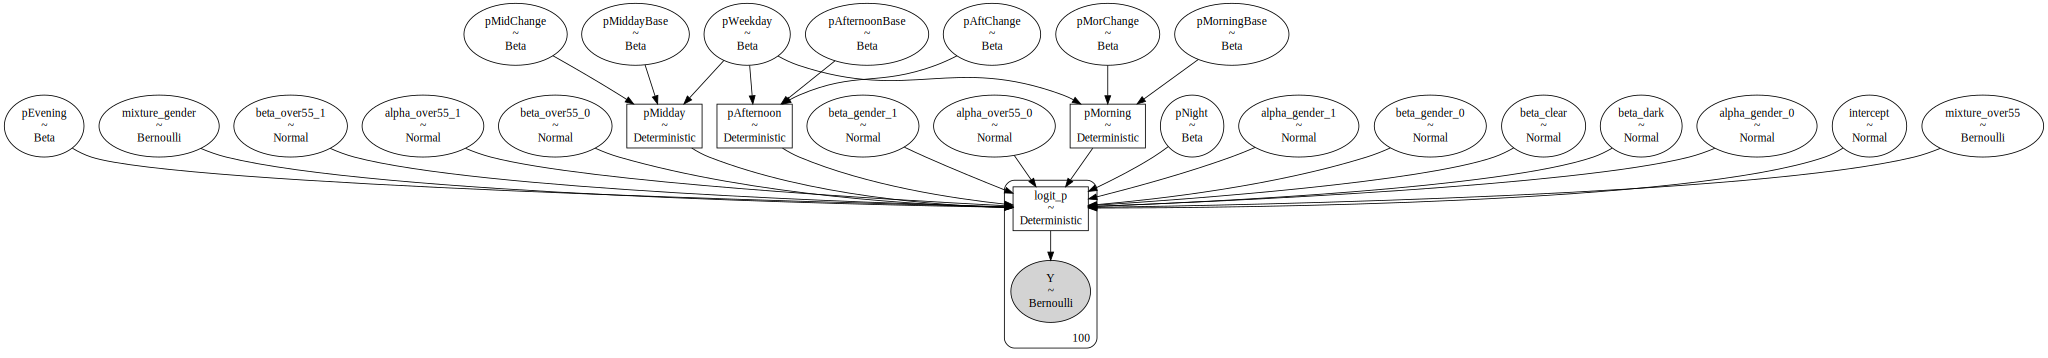

In [ ]:
pm.model_to_graphviz(mixture_model)

array([[<Axes: title={'center': 'alpha_gender_1'}>,
        <Axes: title={'center': 'alpha_gender_1'}>],
       [<Axes: title={'center': 'alpha_gender_0'}>,
        <Axes: title={'center': 'alpha_gender_0'}>]], dtype=object)

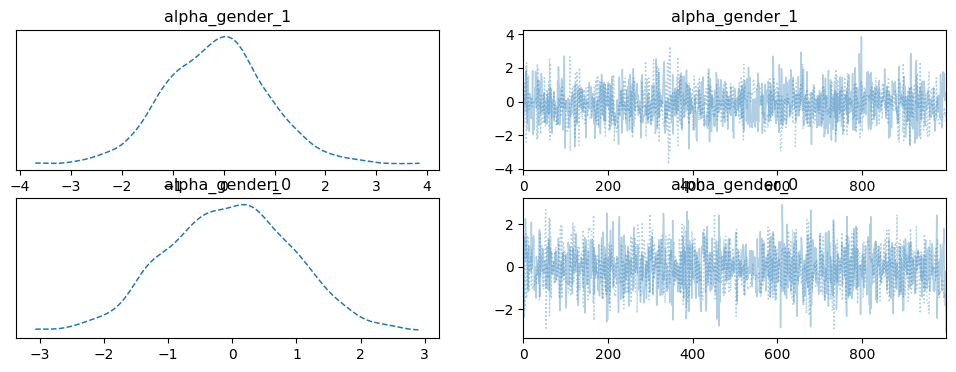

In [ ]:
az.plot_trace(idata_4, var_names=['alpha_gender_1', 'alpha_gender_0'], combined=True) #alpha_over55_1, beta_over55_1, alpha_over55_0, beta_over55_0, alpha_gender_1,alpha_gender_0, beta_gender_0, beta_gender_1, mixture_gender, gender_component

# Model diagnostic Part II



In [ ]:
# Baisc regression model for comparison
with pm.Model() as model_basic:
    beta_0 = pm.Normal('beta_0', mu=0, sigma=1)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=1)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=1)
    beta_3 = pm.Normal('beta_3', mu=0, sigma=1)
    beta_4 = pm.Normal('beta_4', mu=0, sigma=1)
    beta_5 = pm.Normal('beta_5', mu=0, sigma=1)
    beta_dark = pm.Normal('beta_dark', mu=0, sigma=1)  # Prior for 'Dark'
    beta_clear = pm.Normal('beta_clear', mu=0, sigma=1)  # Prior for 'Clear'

    # Linear combination of predictors
    logit_p = beta_0 + beta_1*x6 +beta_2*x7 +beta_3*x8 +beta_4*x9 +beta_5*x10 + beta_clear*x2 + beta_dark*x4
    logit_p = pm.Deterministic('logit_p',logit_p)

    Basic_Y = pm.Bernoulli('Basic_Y', logit_p = logit_p, observed=y)

    idata_3 = pm.sample()

In [ ]:
with mixture_model:
    trace_mix = pm.sample(2000, tune=1000)
    pm.compute_log_likelihood(trace_mix)

with complete_model:
    trace_complete = pm.sample(2000, tune=1000)
    pm.compute_log_likelihood(trace_complete)

with model_basic:
    trace_basic = pm.sample(2000, tune=1000)
    pm.compute_log_likelihood(trace_basic)


In [ ]:
az.waic(trace_mix)

<ipython-input-62-6b3c8ef858ff>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.waic(trace_mix)


Computed from 4000 posterior samples and 100 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -67.99     2.66
p_waic        3.42        -

In [ ]:
az.compare({"mixture model": trace_mix, "complete model": trace_complete, "basic model": trace_basic}, ic='waic')

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
complete model,0,-67.593744,2.679459,0.000000,1.0,2.610005,0.000000,False,log
mixture model,1,-67.988788,3.424237,0.395044,0.0,2.656363,0.345842,False,log
basic model,2,-68.932295,4.490676,1.338552,0.0,2.908771,0.854449,False,log


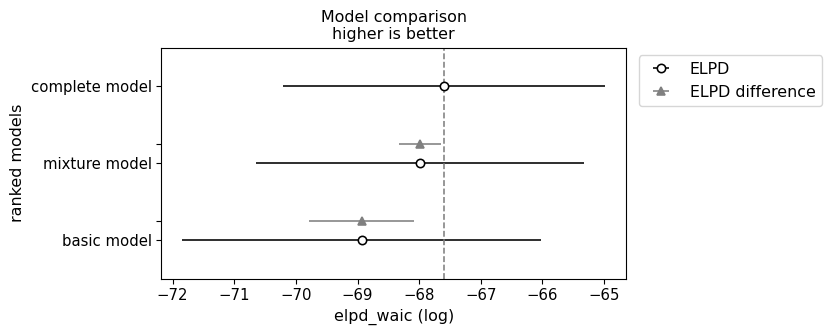

In [ ]:
az.plot_compare(az.compare({"mixture model": trace_mix, "complete model": trace_complete, "basic model": trace_basic}, ic='waic'), insample_dev=False);

# Missing data imputation

In [ ]:
import numpy as np
import pymc as pm
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import itertools

from matplotlib.lines import Line2D
from scipy.stats import multivariate_normal
import matplotlib.cm as cm

# STA365 Missing data imputation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Cyclingdata.csv')
df.head()

Mounted at /content/drive


,Accident_Index,Number_of_Vehicles,Number_of_Casualties,Date,Time,Speed_limit,Road_conditions,Weather_conditions,Day,Road_type,Light_conditions,Gender,Severity,Age_Grp
0,19893389M0115,2,1,1989-05-13,12:50:00,40,Dry,Clear,Saturday,Single carriageway,Daylight,Male,Slight,16 to 20
1,201201CW10530,2,1,2012-03-05,12:10:00,30,Dry,Clear,Thursday,Single carriageway,Daylight,Male,Slight,21 to 25
2,19894200C0467,2,1,1989-04-14,16:55:00,30,Dry,Clear,Friday,Single carriageway,Daylight,Male,Slight,6 to 10
3,2014450012509,2,2,2014-01-14,08:19:00,40,Frost,Unknown,Tuesday,Single carriageway,Daylight,Male,Slight,36 to 45
4,198801DD00558,2,1,1988-11-23,10:20:00,30,Dry,Clear,Wednesday,Dual carriageway,Daylight,Male,Slight,26 to 35


In [ ]:
# Improved version of time getter
def TimeGetter(time):
    """
    Determines the part of the day (Morning, Midday, Afternoon, Evening, Night) based on the given time.

    Parameters:
    - time (str): The time in "HH:MM:SS" format.

    Returns:
    - str: The part of the day as a string ("Morning", "Midday", "Afternoon", "Evening", or "Night").
    """
    hours, minutes, seconds = [int(part) for part in time.split(':')]
    total_seconds = hours * 3600 + minutes * 60 + seconds
    if 6*3600 <= total_seconds < 9*3600:
        return "Morning"
    elif 9*3600 <= total_seconds < 14*3600:
        return "Midday"
    elif 14*3600 <= total_seconds < 18*3600:
        return "Afternoon"
    elif 18*3600 <= total_seconds < 22*3600:
        return "Evening"
    else:
        return "Night"

In [ ]:
# Improved version of data wrangling code
weekday_mapping = {'Monday': 1, 'Tuesday': 1, 'Wednesday': 1, 'Thursday': 1, 'Friday': 1, 'Saturday': 0, 'Sunday': 0}
df['Day'] = df['Day'].map(weekday_mapping)
df["TimeDay"] = df["Time"].apply(TimeGetter)
df["DryRoad"] = (df["Road_conditions"] == "Dry").astype(int)
df["Clear"] = (df["Weather_conditions"] == "Clear").astype(int)
df["Dark"] = (df["Light_conditions"] == "Darkness no lights").astype(int)
df["DualCarriageway"] = (df["Road_type"] == "Dual carriageway").astype(int)
df["over55"] = df["Age_Grp"].isin(["56 to 65", "66 to 75"]).astype(int)
df["Severity_binary"] = (df["Severity"] != "Slight").astype(int)
print(df['Light_conditions'].unique())
for part_of_day in ["Night", "Morning", "Midday", "Afternoon", "Evening"]:
    df[part_of_day] = (df["TimeDay"] == part_of_day).astype(int)
features = ["Severity_binary", "Day", "Speed_limit", "DryRoad", "Clear", "DualCarriageway", "over55", "TimeDay", "Night", "Morning", "Midday", "Afternoon", "Evening", "Dark"]
df2 = df[features]
df2.head(10)

['Daylight' 'Darkness lights lit' 'Darkness no lights']


,Severity_binary,Day,Speed_limit,DryRoad,Clear,DualCarriageway,over55,TimeDay,Night,Morning,Midday,Afternoon,Evening,Dark
0,0,0,40,1,1,0,0,Midday,0,0,1,0,0,0
1,0,1,30,1,1,0,0,Midday,0,0,1,0,0,0
2,0,1,30,1,1,0,0,Afternoon,0,0,0,1,0,0
3,0,1,40,0,0,0,0,Morning,0,1,0,0,0,0
4,0,1,30,1,1,1,0,Midday,0,0,1,0,0,0
5,0,1,30,0,0,0,0,Evening,0,0,0,0,1,0
6,0,1,30,1,0,0,0,Afternoon,0,0,0,1,0,0
7,1,0,30,1,1,0,1,Midday,0,0,1,0,0,0
8,0,1,30,1,1,0,0,Afternoon,0,0,0,1,0,0
9,0,1,40,1,1,0,0,Morning,0,1,0,0,0,0


In [ ]:
df2.shape

(200000, 14)

In [ ]:
df2.isna().sum() #/ len(df)

Severity_binary    0
Day                0
Speed_limit        0
DryRoad            0
Clear              0
DualCarriageway    0
over55             0
TimeDay            0
Night              0
Morning            0
Midday             0
Afternoon          0
Evening            0
Dark               0
dtype: int64

The data set does not contain any missing observations, so I will randomly add missing values to the data set to mimic the scenario and meet the MCAR assumption at the same time. I will also only work with the first 1000 observations.

In [ ]:
df3 = df2[:200]
missingness_percentage = 0.1
np.random.seed(seed=1007501482)
missing_mask = np.random.rand(*df3.shape) < missingness_percentage
for column in df3.columns:
    df3.loc[missing_mask[:, df3.columns.get_loc(column)], column] = np.nan
df3.isna().sum() / len(df3)

Severity_binary    0.145
Day                0.125
Speed_limit        0.075
DryRoad            0.110
Clear              0.105
DualCarriageway    0.100
over55             0.070
TimeDay            0.120
Night              0.110
Morning            0.105
Midday             0.090
Afternoon          0.120
Evening            0.075
Dark               0.130
dtype: float64

In [ ]:
# df4 = df3[['Speed_limit', 'DryRoad', 'Clear',  'DualCarriageway', 'Dark']]
df4 = df3[['Speed_limit', 'DryRoad', 'Clear',  'DualCarriageway', 'Night', 'Morning',
           'Midday',  'Afternoon', 'Evening', 'Dark']]
df4.shape

(200, 10)

I've made a simpler version of the decomposition of the joint distribution. Usually, suppose we have 4 variables $x_1,x_2,x_3, x_4$, then we have the joint distribution
$$p(x_1,x_2,x_3,x_4)=p(x_1)\times p(x_2|x_1)\times p(x_3|x_1,x_2)\times p(x_4|x_1,x_2,x_3)$$
but if all variables are independent, then
$$p(x_1,x_2,x_3,x_4)=p(x_1)\times p(x_2|x_1)\times p(x_3|x_1)\times p(x_4|x_1)$$
My code below draws from the above decomposition of the mixture model with the independence assumption. I will estimate the posterior of `Speed_limit` and then estimate the posterior of the other 9 binary variables as a Bernoulli distribution where $p$ is regressed on `Speed_limit`. If I am to drop the independence assumption, then we would need to estimate 45 $\beta$s and 10 $\alpha$s, which is beyond our computational capacity.

/usr/local/lib/python3.10/dist-packages/pymc/model/core.py:1316: ImputationWarning: Data in speed_limit_pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


/usr/local/lib/python3.10/dist-packages/pymc/model/core.py:1316: ImputationWarning: Data in speed_limit_pred contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


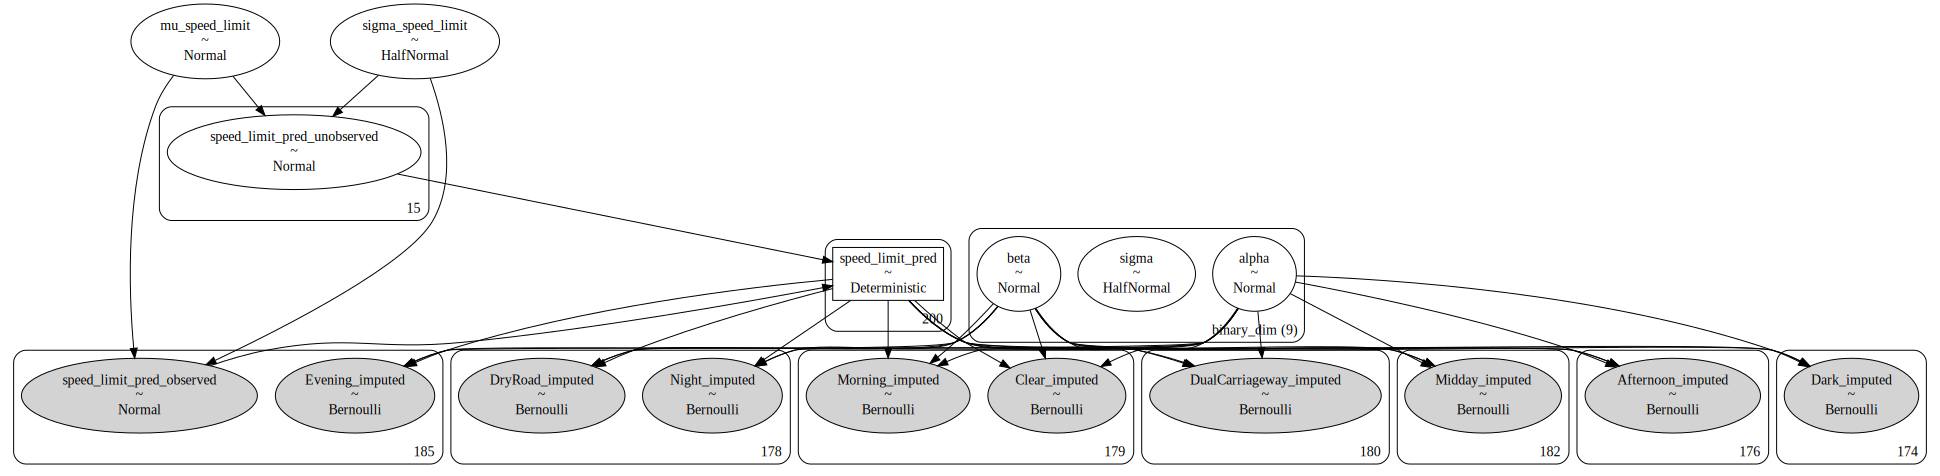

In [ ]:
speed_limit_mean = df4["Speed_limit"].mean()
speed_limit_sd = df4["Speed_limit"].std()
speed_limit_min = df4["Speed_limit"].min()
speed_limit_max = df4["Speed_limit"].max()
priors = {"Speed_limit": {"normal": [speed_limit_mean, speed_limit_sd, speed_limit_sd],
                          "uniform": [speed_limit_min, speed_limit_max]},}


def make_model(priors, normal_pred_assumption=True):
    coords = {"binary_dim": ["DryRoad", "Clear", "DualCarriageway", "Night",
                             "Morning", "Midday", "Afternoon", "Evening", "Dark"],}
    with pm.Model(coords=coords) as model:
      beta = pm.Normal("beta", 0, 1, dims="binary_dim")
      alpha = pm.Normal("alpha", 10, 5, dims="binary_dim")
      sigma = pm.HalfNormal("sigma", 5, dims="binary_dim")

      if normal_pred_assumption:
        mu_speed_limit = pm.Normal("mu_speed_limit", priors["Speed_limit"]["normal"][0],
                                   priors["Speed_limit"]["normal"][1])
        sigma_speed_limit = pm.HalfNormal("sigma_speed_limit",
                                          priors["Speed_limit"]["normal"][2])
        speed_limit_pred = pm.Normal("speed_limit_pred", mu_speed_limit,
                                     sigma_speed_limit, observed=df4["Speed_limit"])
      else:
        speed_limit_pred = pm.Uniform("speed_limit_pred", speed_limit_min,
                                      speed_limit_max, observed=df4["Speed_limit"])

      for i, var in enumerate(coords["binary_dim"]):
        observed = df4[var].dropna()
        mu_binary = alpha[coords["binary_dim"].index(var)] + beta[coords["binary_dim"].index(var)] * speed_limit_pred
        pm.Bernoulli(f"{var}_imputed", pm.math.sigmoid(mu_binary[i]), observed=observed)

      idata = pm.sample_prior_predictive()
      idata.extend(pm.sample(random_seed=1007501482))
      pm.sample_posterior_predictive(idata, extend_inferencedata=True)

    return idata, model


idata_uniform, model_uniform = make_model(priors, normal_pred_assumption=False)
idata_normal, model_normal = make_model(priors, normal_pred_assumption=True)
pm.model_to_graphviz(model_normal)

Next we will do model diagnostics on the imputation model.

In [ ]:
az.summary(idata_normal).head(20)

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (be

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[DryRoad],-0.225,0.121,-0.452,-0.003,0.003,0.002,1616.0,1481.0,1.0
beta[Clear],-0.262,0.167,-0.570,0.052,0.004,0.003,1950.0,955.0,1.0
beta[DualCarriageway],-0.403,0.164,-0.686,-0.068,0.004,0.003,1864.0,1088.0,1.0
beta[Night],-0.319,0.124,-0.545,-0.090,0.003,0.002,2184.0,1308.0,1.0
beta[Morning],-0.390,0.168,-0.690,-0.065,0.004,0.003,2003.0,1148.0,1.0
beta[Midday],-0.381,0.229,-0.823,-0.007,0.007,0.006,1176.0,909.0,1.0
beta[Afternoon],-0.336,0.163,-0.644,-0.033,0.005,0.004,1176.0,990.0,1.0
beta[Evening],-0.372,0.167,-0.689,-0.066,0.004,0.003,1697.0,1217.0,1.0
beta[Dark],-0.466,0.179,-0.783,-0.123,0.005,0.003,1548.0,1076.0,1.0
alpha[DryRoad],9.990,4.849,1.030,19.012,0.121,0.088,1622.0,1506.0,1.0


In [ ]:
az.summary(idata_uniform).head(20)

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (be

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[DryRoad],-0.219,0.129,-0.463,0.016,0.003,0.002,1616.0,1315.0,1.0
beta[Clear],-0.268,0.167,-0.560,0.057,0.004,0.003,1641.0,1247.0,1.0
beta[DualCarriageway],-0.396,0.169,-0.708,-0.071,0.004,0.003,1534.0,1082.0,1.0
beta[Night],-0.323,0.126,-0.547,-0.077,0.003,0.002,1898.0,1427.0,1.0
beta[Morning],-0.395,0.170,-0.722,-0.066,0.004,0.003,1484.0,1052.0,1.0
beta[Midday],-0.301,0.178,-0.654,-0.006,0.004,0.004,1868.0,1441.0,1.0
beta[Afternoon],-0.353,0.167,-0.686,-0.051,0.004,0.003,1826.0,1046.0,1.0
beta[Evening],-0.370,0.163,-0.679,-0.082,0.004,0.003,1955.0,1162.0,1.0
beta[Dark],-0.462,0.168,-0.760,-0.146,0.004,0.003,1552.0,1040.0,1.0
alpha[DryRoad],9.750,5.136,0.288,19.468,0.128,0.091,1617.0,1297.0,1.0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'mu_speed_limit'}>,
        <Axes: title={'center': 'mu_speed_limit'}>],
       [<Axes: title={'center': 'speed_limit_pred_unobserved'}>,
        <Axes: title={'center': 'speed_limit_pred_unobserved'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'sigma_speed_limit'}>,
        <Axes: title={'center': 'sigma_speed_limit'}>],
       [<Axes: title={'center': 'speed_limit_pred'}>,
        <Axes: title={'center': 'speed_limit_pred'}>]], dtype=object)

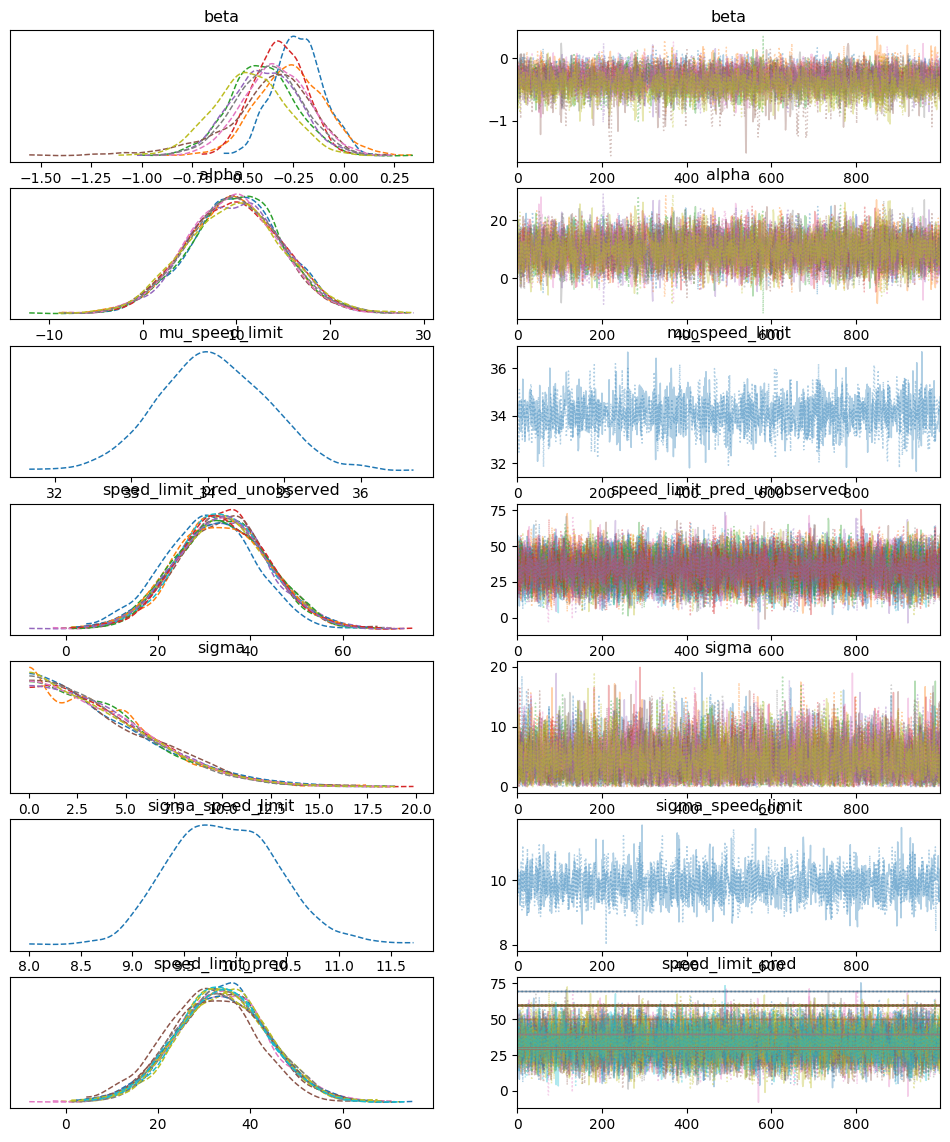

In [ ]:
az.plot_trace(idata_normal, combined=True)

/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'speed_limit_pred_unobserved'}>,
        <Axes: title={'center': 'speed_limit_pred_unobserved'}>],
       [<Axes: title={'center': 'speed_limit_pred'}>,
        <Axes: title={'center': 'speed_limit_pred'}>]], dtype=object)

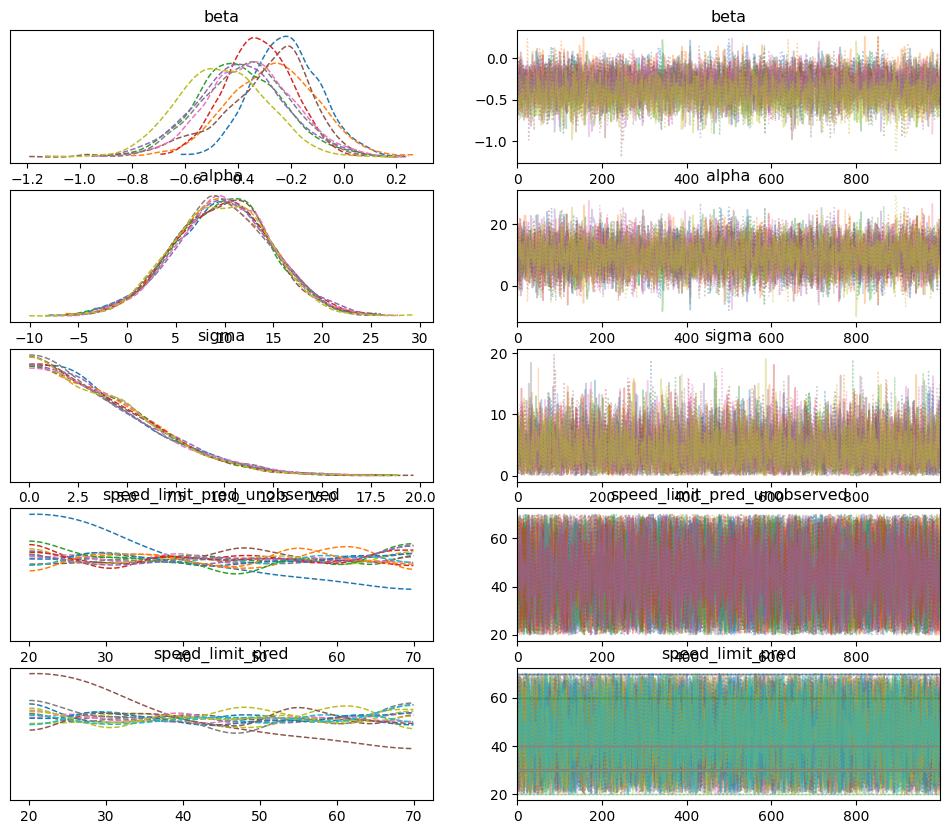

In [ ]:
az.plot_trace(idata_uniform, combined=True)

array([<Axes: >], dtype=object)

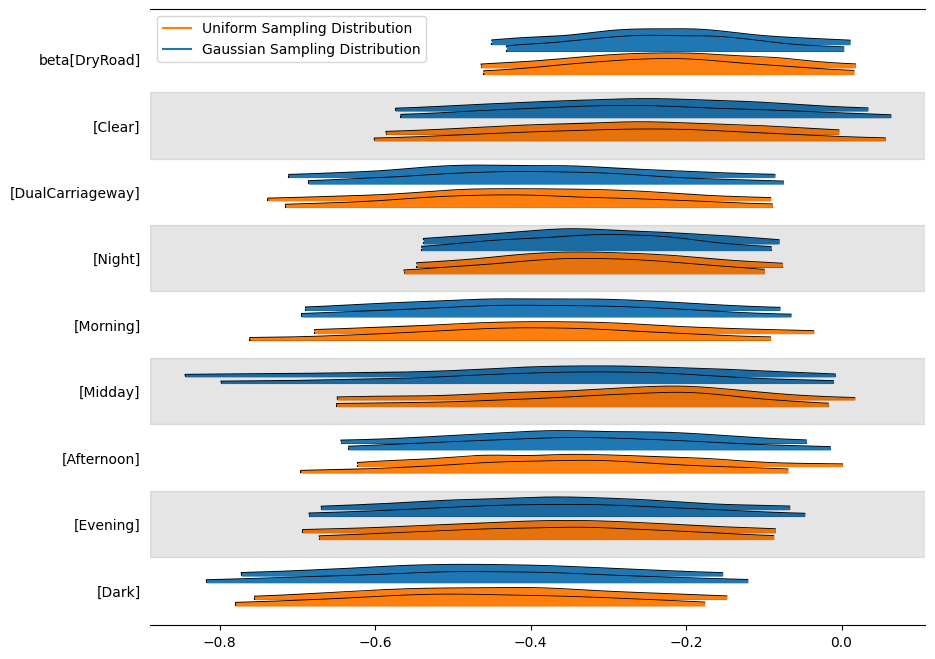

In [ ]:
az.plot_forest(
    [idata_normal, idata_uniform],
    var_names=["beta"],
    kind="ridgeplot",
    model_names=["Gaussian Sampling Distribution", "Uniform Sampling Distribution"],
    figsize=(10, 8),
)

array([[<Axes: xlabel='speed_limit_pred_observed / speed_limit_pred_observed'>,
        <Axes: xlabel='DryRoad_imputed / DryRoad_imputed'>,
        <Axes: xlabel='Clear_imputed / Clear_imputed'>],
       [<Axes: xlabel='DualCarriageway_imputed / DualCarriageway_imputed'>,
        <Axes: xlabel='Night_imputed / Night_imputed'>,
        <Axes: xlabel='Morning_imputed / Morning_imputed'>],
       [<Axes: xlabel='Midday_imputed / Midday_imputed'>,
        <Axes: xlabel='Afternoon_imputed / Afternoon_imputed'>,
        <Axes: xlabel='Evening_imputed / Evening_imputed'>],
       [<Axes: xlabel='Dark_imputed / Dark_imputed'>, <Axes: >, <Axes: >]],
      dtype=object)

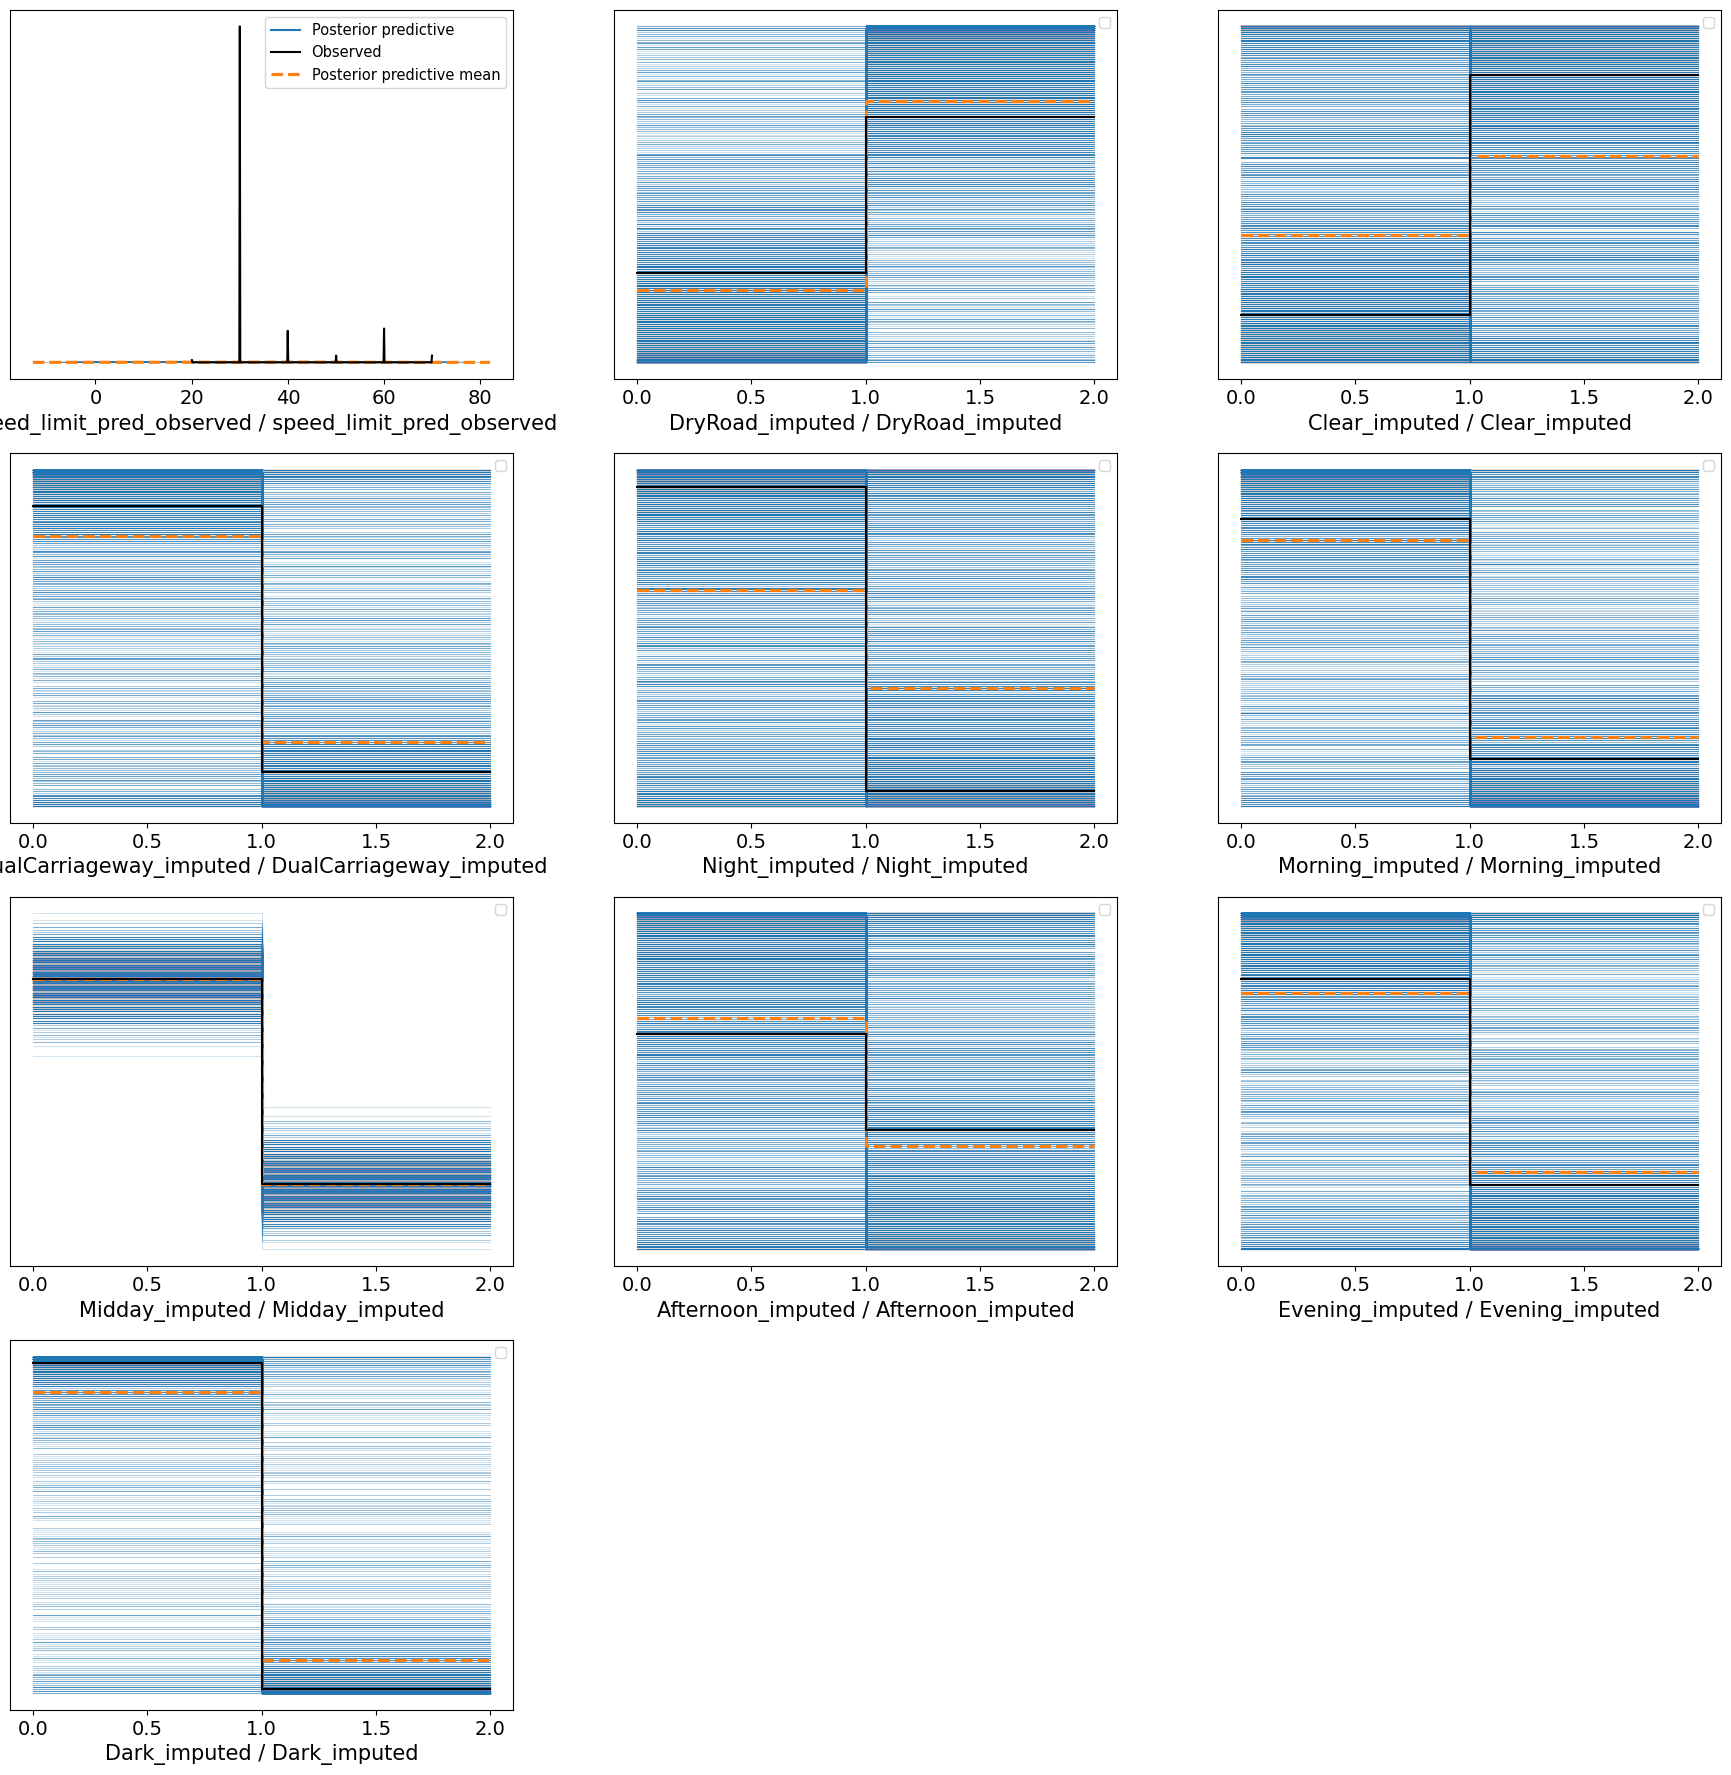

In [ ]:
az.plot_ppc(idata_normal)

array([[<Axes: xlabel='speed_limit_pred_observed / speed_limit_pred_observed'>,
        <Axes: xlabel='DryRoad_imputed / DryRoad_imputed'>,
        <Axes: xlabel='Clear_imputed / Clear_imputed'>],
       [<Axes: xlabel='DualCarriageway_imputed / DualCarriageway_imputed'>,
        <Axes: xlabel='Night_imputed / Night_imputed'>,
        <Axes: xlabel='Morning_imputed / Morning_imputed'>],
       [<Axes: xlabel='Midday_imputed / Midday_imputed'>,
        <Axes: xlabel='Afternoon_imputed / Afternoon_imputed'>,
        <Axes: xlabel='Evening_imputed / Evening_imputed'>],
       [<Axes: xlabel='Dark_imputed / Dark_imputed'>, <Axes: >, <Axes: >]],
      dtype=object)

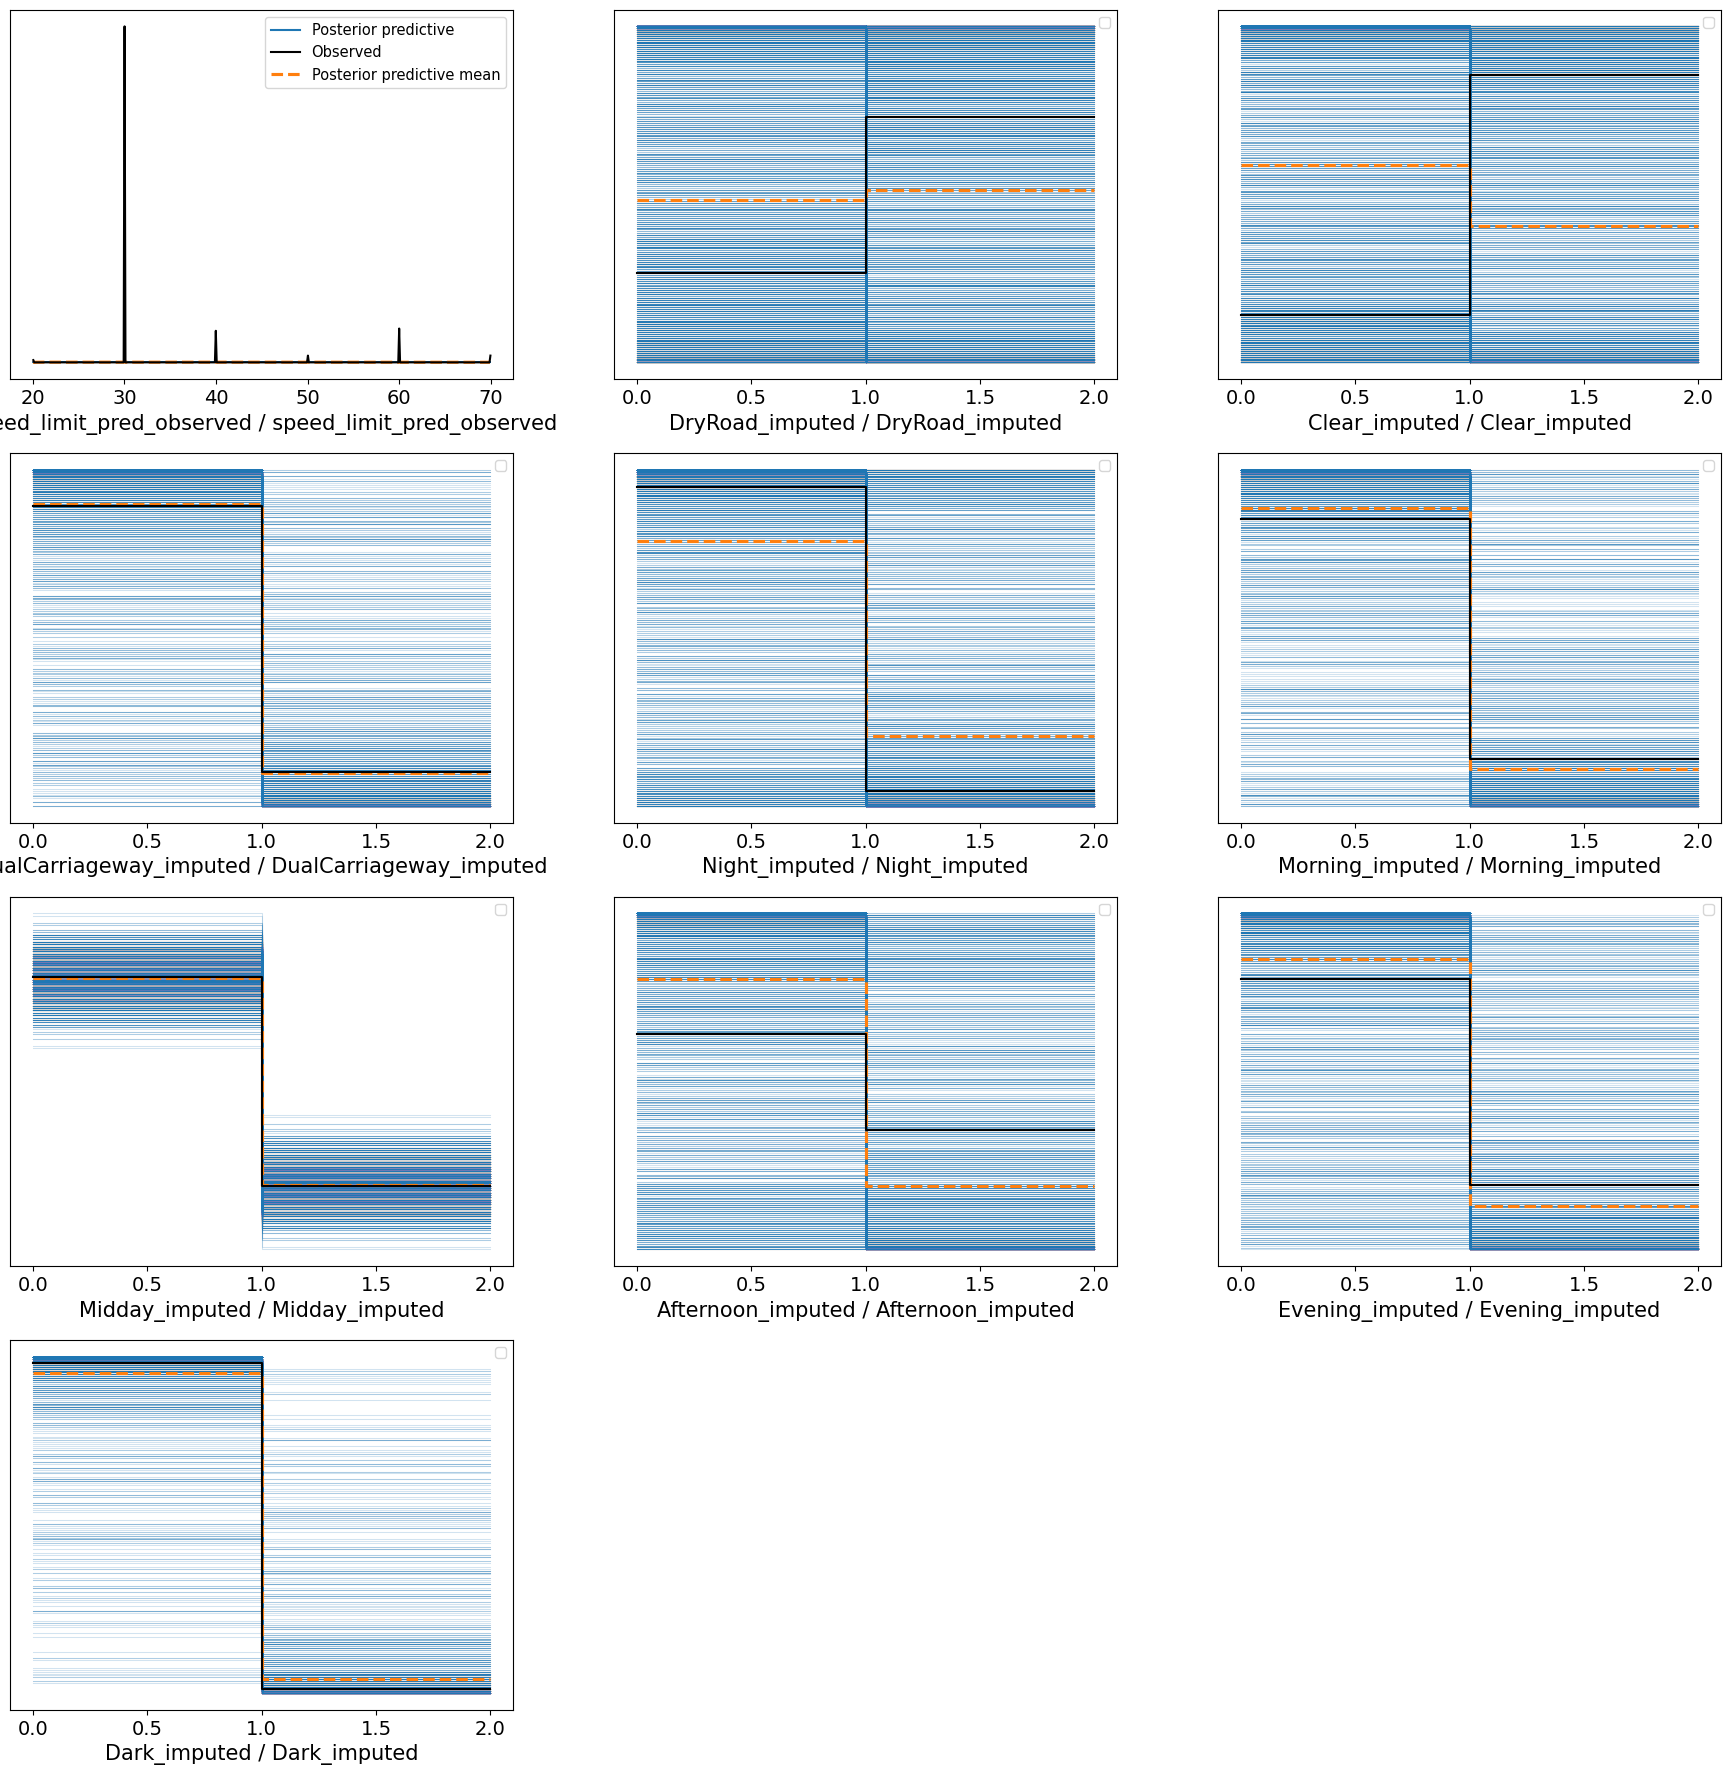

In [ ]:
az.plot_ppc(idata_uniform)

We will obtain the imputed values and plot them.

In [ ]:
def get_imputed(idata, data):
    imputed_data = data.copy()

    imputed_speed_limit = az.extract(idata, group="posterior_predictive",
                                     num_samples=200)["speed_limit_pred"].mean(axis=1)
    mask = imputed_data["Speed_limit"].isnull()
    imputed_data.loc[mask, "Speed_limit"] = imputed_speed_limit.values[imputed_data[mask].index]

    for var in ["DryRoad", "Clear", "DualCarriageway", "Night", "Morning",
                "Midday", "Afternoon", "Evening", "Dark"]:
        imputed_var = az.extract(idata, group="posterior_predictive", num_samples=200)[f"{var}_imputed"].mean(axis=1)
        imputed_var = np.round(imputed_var, 0)
        mask = imputed_data[var].isnull()
        #imputed_data.loc[mask, var] = imputed_var.values[imputed_data[mask].index]
        imputed_data.loc[mask, var] = imputed_var[:mask.sum()]

    assert imputed_data.isnull().sum().sum() == 0, "Some variables still contain missing values after imputation."
    imputed_data.columns = ["imputed_" + col for col in imputed_data.columns]

    return imputed_data


imputed_data_normal = get_imputed(idata_normal, df4)
imputed_data_uniform = get_imputed(idata_uniform, df4)
imputed_data_normal.head(5)

,imputed_Speed_limit,imputed_DryRoad,imputed_Clear,imputed_DualCarriageway,imputed_Night,imputed_Morning,imputed_Midday,imputed_Afternoon,imputed_Evening,imputed_Dark
0,40.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,30.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,30.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,30.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


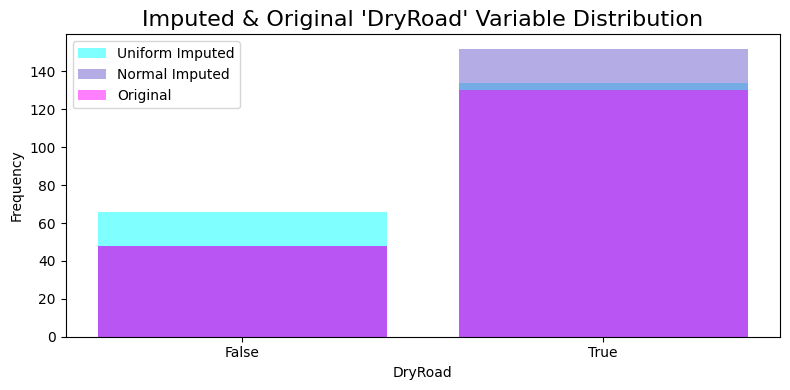

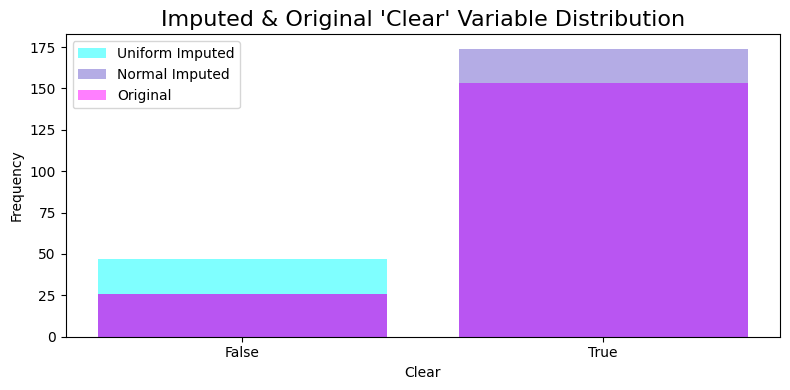

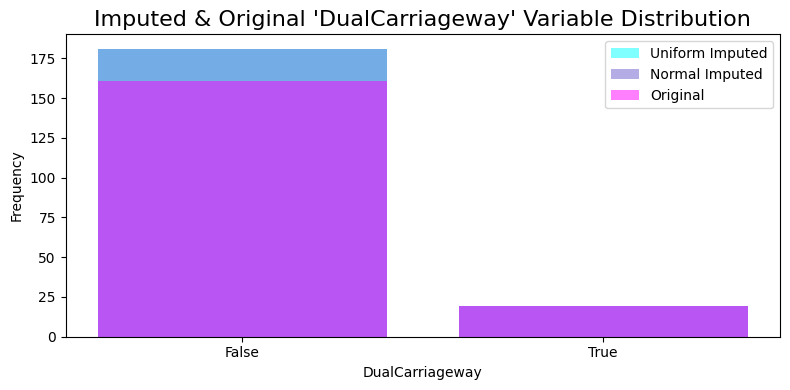

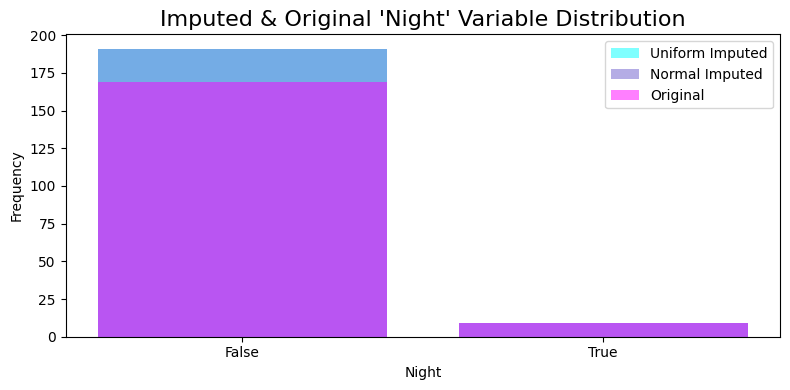

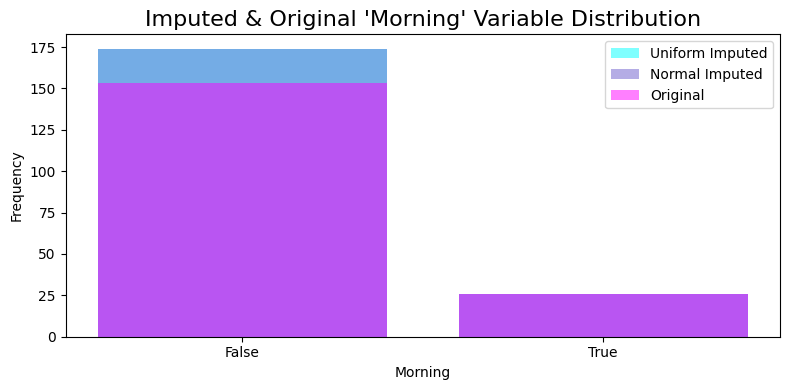

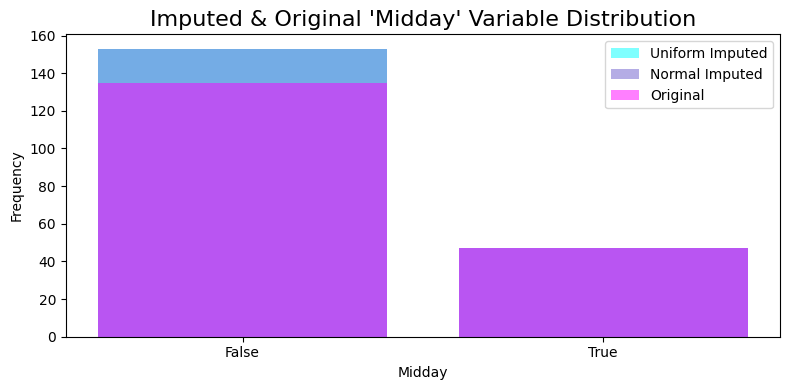

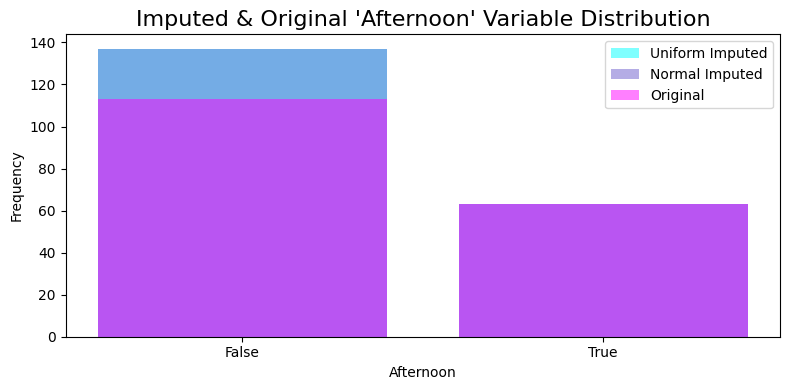

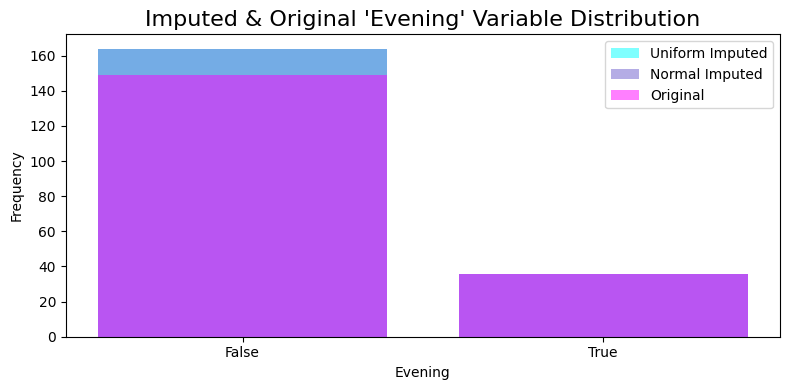

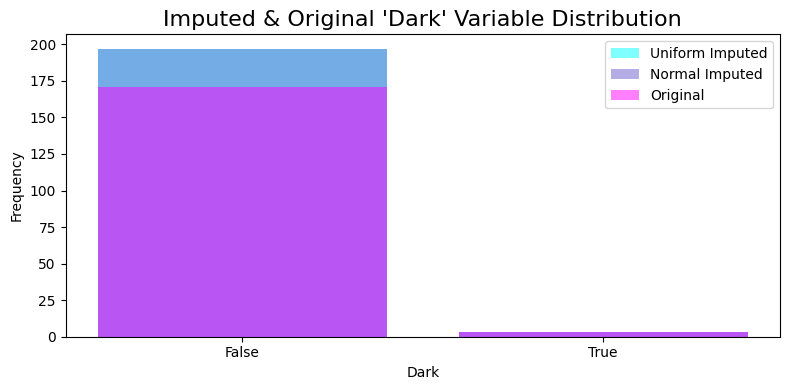

In [ ]:
def plot_binary_variable_distribution(data_original, data_uniform, data_normal, variable_name):
    fig, ax = plt.subplots(figsize=(8, 4))
    bins = [-0.5, 0.5, 1.5]
    labels = ["False", "True"]
    alpha = 0.5
    rwidth = 0.8
    ax.hist(data_uniform["imputed_"+variable_name], bins=bins, alpha=alpha, label="Uniform Imputed", color="cyan", rwidth=rwidth)
    ax.hist(data_normal["imputed_"+variable_name], bins=bins, alpha=alpha, label="Normal Imputed", color="slateblue", rwidth=rwidth)
    ax.hist(data_original[variable_name], bins=bins, alpha=alpha, label="Original", color="magenta", rwidth=rwidth)
    ax.legend()
    ax.set_title(f"Imputed & Original '{variable_name}' Variable Distribution", fontsize=16)
    ax.set_xlabel(variable_name)
    ax.set_ylabel("Frequency")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(labels)

    plt.tight_layout()
    plt.show()


binary_variables = ["DryRoad", "Clear", "DualCarriageway", "Night", "Morning",
                    "Midday", "Afternoon", "Evening", "Dark"]

for variable in binary_variables:
    plot_binary_variable_distribution(df4, imputed_data_uniform, imputed_data_normal, variable)

In [ ]:
def retrieve_original_values(original_df, modified_df, column_name):
    """
    Function to retrieve the original values of a column before missingness was introduced.

    Parameters:
    - original_df: The original DataFrame before missing values were introduced.
    - modified_df: The modified DataFrame with missing values.
    - column_name: The name of the column for which to retrieve original values.

    Returns:
    A pandas Series containing the original values of the specified column.
    """
    if column_name in original_df.columns and column_name in modified_df.columns:
        original_values = original_df[column_name].where(modified_df[column_name].isna(), modified_df[column_name])
        return original_values
    else:
        raise ValueError("Column name not found in one of the DataFrames.")


df5 = df2[['Speed_limit', 'DryRoad', 'Clear',  'DualCarriageway', 'Night', 'Morning',
           'Midday',  'Afternoon', 'Evening', 'Dark']]
df5 = df5[:200]

In [ ]:
def compare_distributions(imputed_data_uniform, imputed_data_normal, variable_name):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(retrieve_original_values(df5, df4, variable_name), bins=30, alpha=0.5, label="Original", color="purple")
    ax.hist(imputed_data_uniform["imputed_"+variable_name], bins=30, alpha=0.5, label="Uniform Imputed", color="cyan")
    ax.hist(imputed_data_normal["imputed_"+variable_name], bins=30, alpha=0.5, label="Normal Imputed", color="magenta")
    ax.legend()
    ax.set_title(f"Distribution of {variable_name}: Original vs Imputed")
    ax.set_xlabel(variable_name)
    ax.set_ylabel("Frequency")
    plt.show()

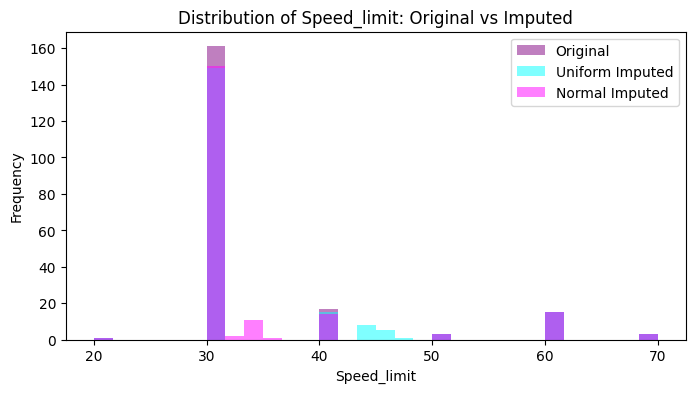

In [ ]:
compare_distributions(imputed_data_uniform= imputed_data_uniform,
                      imputed_data_normal=imputed_data_normal,
                      variable_name="Speed_limit")

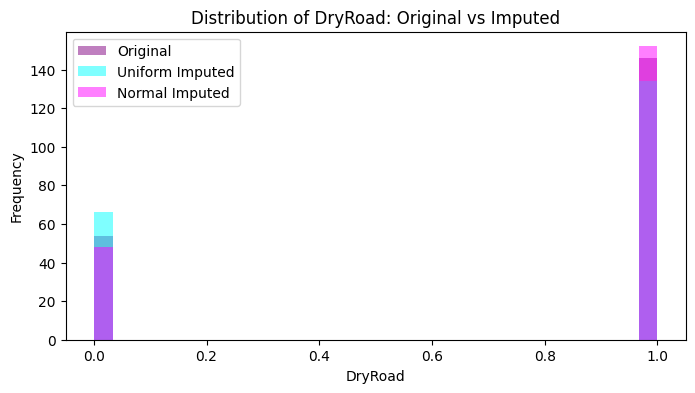

In [ ]:
compare_distributions(imputed_data_uniform, imputed_data_normal, "DryRoad")